![title](bigbang-logo-dark-small.png)

# CLBE BigBang Tutorial

Many Standards Development Organizations have working groups that organize themselves through mailing lists. This mailing list data is a valuable source of research insights but can be challenging to gather and analyze. BigBang is an open source toolkit for studying processes of open collaboration and deliberation via analysis of the communications records. Its tools for collecting, analyzing, and visualizing mailing list data are used by a community of information policy researchers to study participation trends and interaction in these settings. This tutorial is a hands-on introduction to the toolkit’s capabilities.

## BigBang overview

**TODO**

### Why the project exists

**TODO**

### Open source scientific software – how to think about its role in research

**TODO**



## Installation and community


### Python Installation

This tutorial assumes that you have Python installed on your system.

**TODO**: How to do a local installation.

### How to get help

- Documentation website: https://bigbang-py.readthedocs.io/en/latest/
  - The most polished overview of the software and its functionality to date
- GitHub: https://github.com/datactive/bigbang
  - The issue tracker here is a good place to post problems you have with the software.
- Mailing list: https://lists.ghserv.net/mailman/listinfo/bigbang-dev
  - Open to all discussions of the software, including "Help me!" questions.
- Biweekly video call

## Data Ingress

BigBang aims to make streamline the process of collecting data from SDOs.

Its most robust tools are built for collecting and process email records.

We will also demonstrate how data from other sources can be integrated into an analysis.

In the future, we hope to support gathering of other data, such as data from GitHub projects and Discourse forums.

### Email

#### Sources - 3GPP, IETF, W3C, ICANN, RIPE, etc.

**TODO**

### IETF DataTracker

#### Reminder about download link

**TODO**

#### Command line tools

Example commands

**TODO**

**TODO** Add `v6ops`

In [28]:
!python bin/collect_mail.py -u https://www.ietf.org/mail-archive/text/v6ops/
!python bin/collect_mail.py -u https://www.ietf.org/mail-archive/text/dtn-security/
!python bin/collect_mail.py -u https://www.ietf.org/mail-archive/text/tls-reg-review/

python: can't open file '/home/sb/projects/bigbang/examples/bin/collect_mail.py': [Errno 2] No such file or directory
python: can't open file '/home/sb/projects/bigbang/examples/bin/collect_mail.py': [Errno 2] No such file or directory
python: can't open file '/home/sb/projects/bigbang/examples/bin/collect_mail.py': [Errno 2] No such file or directory


### IETF Datatracker

### Provided Data

Email domain categories


## Analysis Tools

### Activity

In [29]:
from bigbang.archive import Archive

mls = ["dtn-security", "tls-reg-review", "httpbisa", "v6ops"]

arxs = [Archive(ml) for ml in mls]

acts = [arx.get_activity() for arx in arxs]

<AxesSubplot:xlabel='Date'>

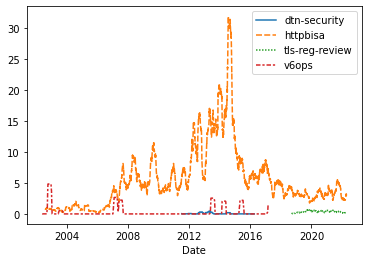

In [30]:
from datetime import date
import pandas as pd
import seaborn as sns

sum_acts = pd.DataFrame.from_records({mls[i] : a.sum(1) for i,a in enumerate(acts)})
sum_acts.index = sum_acts.index.map(date.fromordinal)
window = 100


sns.lineplot(data=sum_acts.rolling(window).mean().dropna(how='all'))

### Word Trends

Extra installation step.

In [31]:
### Maybe move this into a module loaded as a script to get it out of the way.

import nltk
nltk.download('punkt')

from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

import re
def count_word(text, word, stem = False):
    if not text:
        return 0
    
    if len(word.split(" ")) <= 1:
        ## normalize the text - remove apostrophe and punctuation, lower case
        normalized_text = re.sub(r'[^\w]', ' ',text.replace("'","")).lower()
    
        tokenized_text = nltk.tokenize.word_tokenize(normalized_text)

        if stem:
            tokenized_text = [st.stem(t) for t in tokenized_text]
    
        return tokenized_text.count(word)
    else:
        return text.lower().count(word)

[nltk_data] Downloading package punkt to /home/sb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
checkwords = ["security", "privacy", "header"]

In [33]:
arx_word_data = {}

In [34]:
for i, arx in enumerate(arxs):
    data = arx.data.copy()
    dates = data['Date'].map(lambda x: x.date())
    data['Date'] = dates
    
    for word in checkwords:
        data[word] = data['Body'].apply(lambda x: count_word(x,word))
        
        arx_word_data[f"{mls[i]} {word}"] = data.groupby('Date')[word].sum()

word_data = pd.DataFrame(arx_word_data)

In [35]:
new_date_range = pd.date_range(start=word_data.index.min(), end=word_data.index.max(), freq="D")
word_data = word_data.reindex(new_date_range, fill_value=0)  
word_data = word_data.fillna(0)

<AxesSubplot:>

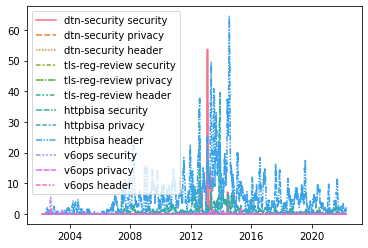

In [36]:
window = 30

sns.lineplot(data=word_data.rolling(window).mean().dropna(how='all'))

## More analysis

- Visualizing Interactions https://github.com/datactive/bigbang/tree/main/examples/network_analysis
    - Individuals
    - Domains https://github.com/datactive/bigbang/tree/main/examples/organizations

- Gender, Geography, and Tenure https://github.com/datactive/bigbang/tree/main/examples/name-and-gender

In [37]:
from bigbang.archive import Archive
import bigbang.parse as parse
from bigbang.analysis.utils import extract_domain
import bigbang.analysis.graph as graph
import bigbang.ingress.mailman as mailman
import bigbang.analysis.process as process
import networkx as nx
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz


def draw_interaction_graph(ig, threshold = .15):
    ig = ig.copy()
    max_sent = max([data['sent'] for name,data in ig.nodes(data=True)])
    ig.remove_nodes_from([name for name,data in ig.nodes(data=True) if data['sent'] < threshold * max_sent])
    
    edges, weights = zip(*nx.get_edge_attributes(ig, 'weight').items())
    weights_multiplier = 50.0 / max(weights)
    weights = [w * weights_multiplier for w in weights]

    pos = nx.shell_layout(ig)
    
    node_size_multiplier = 1000 / max([data['sent'] for name,data in ig.nodes(data=True)])
    node_size = [data['sent'] * node_size_multiplier for name,data in ig.nodes(data=True)]
    
    #node_size = np.array([x*1e3 for x in nx.degree_centrality(DG).values()])
    #bounds = np.linspace(np.min(node_size), np.max(node_size), len(node_size))
    #norm = colors.BoundaryNorm(bounds, plt.cm.rainbow.N)

    nx.draw(
        ig,
        pos,
        with_labels=False,
        node_size = node_size,
        node_color = '#CCCCFF',
        alpha = 0.8,
        font_size=12,
        #font_weight='bold',
        edgelist=edges,
        width=weights,
        edge_color=weights,
        edge_cmap=plt.cm.viridis,
    )
    
    # some math labels
    labels = {node : str(node)[:15]for node in ig.nodes}
    nx.draw_networkx_labels(ig, pos, labels, font_size=12) #font_color="whitesmoke"


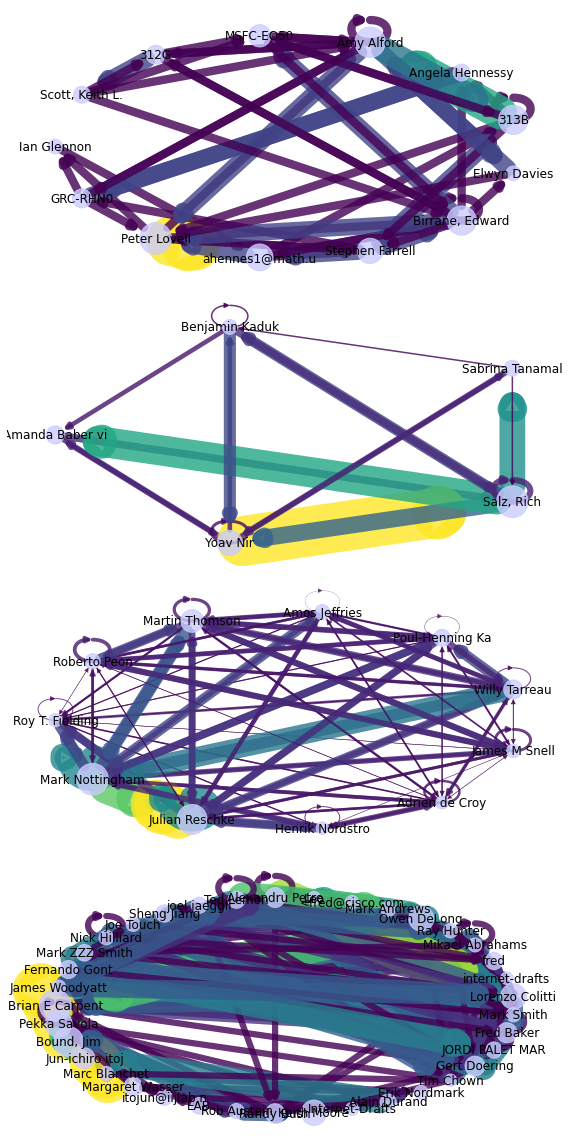

In [38]:
figdim = len(arxs) * 100 + 10
    
plt.figure(figdim,figsize=(8, 16))
for i,arx in enumerate(arxs):
    plt.subplot(figdim + i + 1) # create a subplot keyed to the index of this ml
    df = arx.data.copy()
    ig = graph.messages_to_interaction_graph(df)
    draw_interaction_graph(ig)

plt.tight_layout()
plt.show()

In [39]:
len(ig.nodes)

603

### Email domains

**TODO** Label these charts

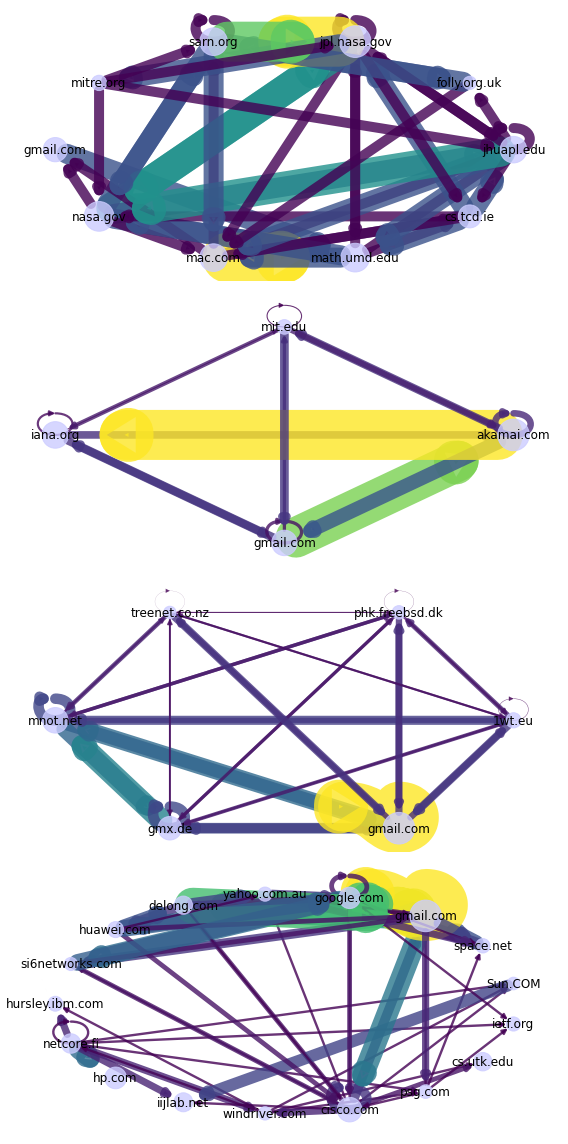

In [40]:
figdim = len(arxs) * 100 + 10
    
plt.figure(figdim,figsize=(8, 16))
for i,arx in enumerate(arxs):
    plt.subplot(figdim + i + 1) # create a subplot keyed to the index of this ml
    df = arx.data.copy()
    
    ## could make this cleaner -- move more to the library
    df['domain'] = df['From'].map(extract_domain)
    df['From'] = df['domain']
    df = df.dropna(subset='From')
    
    ig = graph.messages_to_interaction_graph(df, clean = False)
    draw_interaction_graph(ig)

plt.tight_layout()
plt.show()

### Organizations

In [41]:
import bigbang.datasets.organizations as organizations
org_data = organizations.load_data()

In [42]:
org_data.head()

,name,category,subsidiary of / alias of,stakeholdergroup,nationality,email domain names,Membership Organization,Wiki Page
0,Universidad Tecnológica Nacional,Research Institution,NaN,Academia,Argentina,NaN,NaN,NaN
1,Attorney-General's Department Australian Gove...,NaN,NaN,Government,Australia,NaN,ETSI,NaN
2,COMMUNICATIONS ALLIANCE LTD,Association,NaN,Business,Australia,NaN,OTHER,NaN
3,Softel Systems Pty Ltd,Cybersecurity,NaN,Business,Australia,softelsystems.com.au,ETSI,NaN
4,Telstra Corporation Limited,Telecommunications Provider,NaN,Business,Australia,team.telstra.com,ETSI,NaN


### Gender

In [43]:
from gender_detector import gender_detector as gd

In [46]:
detector = gd.GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

series = []  
for i, arx in enumerate(arxs):
    activity = Archive.get_activity(arx).sum(0)
    activityFrame = pd.DataFrame(activity, columns=['Message Count'])
    
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_from(x))    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    activityFrame.to_csv(('senders_guessed_gender-%s.csv' % mls[i]),encoding='utf-8')
    
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].count()
    counts.name=mls[i]
    series.append(counts)

pd.DataFrame(series)

Guessed Gender,female,male,name unknown,unknown,error
dtn-security,2.0,9.0,15.0,3.0,NaN
tls-reg-review,3.0,35.0,25.0,3.0,2.0
httpbisa,61.0,864.0,398.0,414.0,7.0
v6ops,95.0,191.0,193.0,153.0,NaN


## Q & A  and Feature Requests-
